In [1]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


Is CUDA available: True
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
%run "PDF text cleaning.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  100 non-null    int64 
 1   id          100 non-null    object
 2   title       100 non-null    object
 3   abstract    100 non-null    object
 4   published   100 non-null    object
 5   pdf_url     100 non-null    object
 6   full_text   99 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB
Paper ID: 9907025v1

Abstract: We provide a lower bound construction showing that the union of unit balls in
three-dimensional space has quadratic complexity, even if they all contain the
origin. This settles a conjecture of Sharir.

Clean Text: 
1 Introduction The union of a set of n balls in R 3 has quadratic complexity Θ(n ), even if they all have the same radius. All the already known constructions have balls scattered around, however, and Sharir posed the problem whether a quad

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import logging

import logging

# Set up basic configuration for logging
logging.basicConfig(
    level=logging.INFO,  # You can change this to DEBUG for more details
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Create a logger object
logger = logging.getLogger(__name__)



# Download NLTK data
nltk.download('punkt', quiet=True)

True

In [4]:

def tfidf_summarize(text, top_n = 25):
    
    try:
        # Validate input
        if not isinstance(text, str):
            raise ValueError("Input text must be a string.")
        
        sentences = sent_tokenize(text)
        
        # Handle edge cases
        if not sentences:  # Empty input
            return "Error: No valid sentences found in text."
        if top_n <= 0:
            raise ValueError("Error: top_n must be greater than zero.")
        if len(sentences) <= top_n:
            return text  # If fewer sentences than top_n, return original text
        
        # Apply TF-IDF
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)
        # Compute sentence scores
        sentence_scores = np.array(tfidf_matrix.sum(axis = 1)).ravel()
        top_indices = sentence_scores.argsort()[-top_n:][::-1]
        top_sentences = [sentences[i] for i in sorted(top_indices)]
        
        return ' '.join(top_sentences)
    
    except ValueError as ve:
        return f"ValueError: {ve}"
    except Exception as e:
        return f"Unexpected error: {str(e)}"


In [5]:
def batch_tfidf_summarize(texts, top_n=25):

    try:
        # Validate input
        if not isinstance(texts, list):
            raise ValueError("Input must be a list of texts.")
        
        # Process each text in the batch
        results = []
        for i, text in enumerate(texts):
            try:
                summary = tfidf_summarize(text, top_n)
                results.append(summary)
            except Exception as e:
                # Catch errors for individual texts without stopping the batch
                results.append(f"Error in document {i}: {str(e)}")
        
        return results
    
    except ValueError as ve:
        return [f"ValueError: {ve}"]
    except Exception as e:
        return [f"Unexpected error in batch processing: {str(e)}"]

In [6]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

def led_summarize(text, max_input_length=4096, max_output_length=1024):

    try:
        # Load model and tokenizer
        model_name = "allenai/led-base-16384"  
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        
        # Check for GPU availability
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
        
        # Tokenize with attention mask that allows the model to attend to all tokens
        inputs = tokenizer(text, 
                          max_length=max_input_length, 
                          truncation=True, 
                          return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate summary
        global_attention_mask = torch.zeros_like(inputs["input_ids"])
        # Set global attention on the first token
        global_attention_mask[:, 0] = 1
        inputs["global_attention_mask"] = global_attention_mask
        
        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            global_attention_mask=global_attention_mask,
            max_length=max_output_length,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True,
        )
        
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary
    
    except Exception as e:
        return f"LED Summarization Error: {str(e)}"


def batch_led_summarize(texts, max_input_length=4096, max_output_length=1024, batch_size=4):

    try:
        # Validate input
        if not isinstance(texts, list):
            raise ValueError("Input must be a list of texts.")
        
        # Load model and tokenizer once for all texts
        model_name = "allenai/led-base-16384"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        
        # Check for GPU availability
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
        
        results = []
        
        # Process texts in batches to improve efficiency
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_results = []
            
            # Process each text in the current batch
            for text in batch_texts:
                try:
                    # Tokenize
                    inputs = tokenizer(text, 
                                      max_length=max_input_length, 
                                      truncation=True, 
                                      return_tensors="pt")
                    inputs = {k: v.to(device) for k, v in inputs.items()}
                    
                    # Generate summary
                    global_attention_mask = torch.zeros_like(inputs["input_ids"])
                    global_attention_mask[:, 0] = 1
                    inputs["global_attention_mask"] = global_attention_mask
                    
                    with torch.no_grad():  # Disable gradient calculation for inference
                        summary_ids = model.generate(
                            inputs["input_ids"],
                            attention_mask=inputs["attention_mask"],
                            global_attention_mask=global_attention_mask,
                            max_length=max_output_length,
                            num_beams=4,
                            length_penalty=2.0,
                            early_stopping=True,
                        )
                    
                    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
                    batch_results.append(summary)
                    
                except Exception as e:
                    batch_results.append(f"LED Summarization Error: {str(e)}")
            
            results.extend(batch_results)
        
        return results
    
    except ValueError as ve:
        return [f"ValueError: {ve}"]
    except Exception as e:
        return [f"Unexpected error in batch processing: {str(e)}"]


# Alternative implementation with true parallel batch processing
def batch_led_summarize_parallel(
    texts,
    model_name="allenai/led-base-16384",
    max_input_length=4096,
    max_output_length= 1024,
    batch_size=4,
    num_beams=4
):

    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
    import torch
    from tqdm import tqdm

    if not isinstance(texts, list):
        raise ValueError("Input must be a list of texts.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    model.eval()

    summaries = []

    for i in tqdm(range(0, len(texts), batch_size), desc="LED Summarizing"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_length
        )

        # Move input tensors to the correct device
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            summary_ids = model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=max_output_length,
                num_beams=num_beams,
                early_stopping=True
            )

        batch_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        summaries.extend(batch_summaries)

    return summaries


In [7]:
def pipeline_summarize(texts, tfidf_top_n=25, led_max_input_length=4096, led_max_output_length=1024, led_batch_size=4):
    metrics = {
        'tfidf_time': 0,
        'led_time': 0,
        'total_time': 0,
        'original_chars': sum(len(t) for t in texts),
        'tfidf_chars': 0,
        'final_chars': 0
    }
    
    start_total = time.time()
    
    # Step 1: TF-IDF summarization
    logger.info(f"Starting TF-IDF summarization for {len(texts)} documents...")
    start_tfidf = time.time()
    tfidf_summaries = batch_tfidf_summarize(texts, top_n=tfidf_top_n)
    metrics['tfidf_time'] = time.time() - start_tfidf
    metrics['tfidf_chars'] = sum(len(s) for s in tfidf_summaries)
    
    logger.info(f"TF-IDF summarization completed in {metrics['tfidf_time']:.2f} seconds")
    logger.info(f"Original text: {metrics['original_chars']} chars, TF-IDF summaries: {metrics['tfidf_chars']} chars")
    
    # Step 2: LED summarization on TF-IDF results
    logger.info(f"Starting LED summarization on TF-IDF results...")
    start_led = time.time()
    led_summaries = batch_led_summarize_parallel(
        tfidf_summaries, 
        max_input_length=led_max_input_length,
        max_output_length=led_max_output_length,
        batch_size=led_batch_size
    )
    metrics['led_time'] = time.time() - start_led
    metrics['final_chars'] = sum(len(s) for s in led_summaries)
    
    logger.info(f"LED summarization completed in {metrics['led_time']:.2f} seconds")
    logger.info(f"Final summaries: {metrics['final_chars']} chars")
    
    metrics['total_time'] = time.time() - start_total
    logger.info(f"Total pipeline time: {metrics['total_time']:.2f} seconds")
    
    # Calculate compression ratios
    metrics['tfidf_compression'] = metrics['tfidf_chars'] / metrics['original_chars'] if metrics['original_chars'] > 0 else 0
    metrics['final_compression'] = metrics['final_chars'] / metrics['original_chars'] if metrics['original_chars'] > 0 else 0
    
    # Modified return statement to include tfidf_summaries
    return led_summaries, tfidf_summaries, metrics

In [8]:
sample_texts = df['clean'].tolist()
led_summaries, tfidf_summaries, metrics = pipeline_summarize(
    sample_texts, 
    tfidf_top_n = 25,  # Extract top 25 sentences with TF-IDF
    led_max_output_length= 1024  # Generate summaries of up to 1024 tokens
)

# Add summaries to dataframe for ROUGE evaluation
df['tfidf_summaries'] = tfidf_summaries
df['led_summaries'] = led_summaries

# Print results
print("\n=== FINAL SUMMARIES ===")
for i, summary in enumerate(led_summaries):
    print(f"\nDocument {i+1} summary:")
    print(summary)
    
print("\n=== PERFORMANCE METRICS ===")
print(f"Original text: {metrics['original_chars']} characters")
print(f"After TF-IDF: {metrics['tfidf_chars']} characters ({metrics['tfidf_compression']*100:.1f}% of original)")
print(f"Final summaries: {metrics['final_chars']} characters ({metrics['final_compression']*100:.1f}% of original)")
print(f"TF-IDF time: {metrics['tfidf_time']:.2f} seconds")
print(f"LED time: {metrics['led_time']:.2f} seconds")
print(f"Total time: {metrics['total_time']:.2f} seconds")



2025-05-09 15:20:54,266 - INFO - Starting TF-IDF summarization for 99 documents...
2025-05-09 15:20:56,829 - INFO - TF-IDF summarization completed in 2.56 seconds
2025-05-09 15:20:56,829 - INFO - Original text: 3953284 chars, TF-IDF summaries: 667407 chars
2025-05-09 15:20:56,829 - INFO - Starting LED summarization on TF-IDF results...
LED Summarizing: 100%|██████████| 25/25 [08:40<00:00, 20.81s/it]
2025-05-09 15:29:43,378 - INFO - LED summarization completed in 526.54 seconds
2025-05-09 15:29:43,378 - INFO - Final summaries: 294904 chars
2025-05-09 15:29:43,378 - INFO - Total pipeline time: 529.11 seconds



=== FINAL SUMMARIES ===

Document 1 summary:
, and Mariette Yvinec.

Document 2 summary:
, vn} and edge set E(G), where e(G) is the number of edges of G. The adjacency matrix A(G) = (aij ) of G is the n × n matrix, where aij = 1 if viis adjacent to vj , and otherwise. ∗This work is supported by the Joint NSFC-ISF Research Program (jointly funded by the National Natural Science Foundation of China and the Israel Science Foundation (No. E-mail: xiaodong@sjtu.edu.cn 1The problem of maximizing the number of edges over all graphs without containing fixed subgraphs is one of the cornerstones of graph theory. For example, if yk has a neighbour in W1, without loss of generality, say x1, then S 2≤i≤k−1 Qi together with a disjoint P3 with center yk and two ends u, z yield k · P3, a contradiction. If yk has a neighbour in W1, without loss of generality, say x1, then S 2≤i≤k−1 Qi together with zy1z1 and uykx1 will yield k · P3, where z is a neighbour of y1 in W\W1. Since G is 2 · P3-free, G has e

In [9]:
def calculate_rouge_scores(reference_text, generated_summary):

    try:
        # Initialize ROUGE scorer with the metrics we want to use
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        
        # Calculate scores
        scores = scorer.score(reference_text, generated_summary)
        
        # Extract F1 scores (balance of precision and recall)
        rouge1_f1 = scores['rouge1'].fmeasure
        rouge2_f1 = scores['rouge2'].fmeasure
        rougeL_f1 = scores['rougeL'].fmeasure
        
        return {
            'rouge1_f1': rouge1_f1,
            'rouge2_f1': rouge2_f1,
            'rougeL_f1': rougeL_f1,
            'average_f1': np.mean([rouge1_f1, rouge2_f1, rougeL_f1])
        }
    except Exception as e:
        print(f"Error calculating ROUGE scores: {str(e)}")
        return {
            'rouge1_f1': 0.0,
            'rouge2_f1': 0.0,
            'rougeL_f1': 0.0,
            'average_f1': 0.0
        }

In [10]:
# Calculate ROUGE scores if needed
print("\n=== CALCULATING ROUGE SCORES ===")
print("Calculating ROUGE scores for TF-IDF summaries...")
df['tfidf_rouge'] = df.apply(
    lambda row: calculate_rouge_scores(row['clean'], row['tfidf_summaries']),
    axis=1
)

print("Calculating ROUGE scores for LED summaries...")
df['led_rouge'] = df.apply(
    lambda row: calculate_rouge_scores(row['clean'], row['led_summaries']),
    axis=1
)

2025-05-09 15:29:43,416 - INFO - Using default tokenizer.



=== CALCULATING ROUGE SCORES ===
Calculating ROUGE scores for TF-IDF summaries...


2025-05-09 15:29:43,796 - INFO - Using default tokenizer.
2025-05-09 15:29:46,934 - INFO - Using default tokenizer.
2025-05-09 15:29:50,396 - INFO - Using default tokenizer.
2025-05-09 15:29:58,208 - INFO - Using default tokenizer.
2025-05-09 15:30:02,432 - INFO - Using default tokenizer.
2025-05-09 15:30:03,461 - INFO - Using default tokenizer.
2025-05-09 15:30:05,601 - INFO - Using default tokenizer.
2025-05-09 15:30:12,177 - INFO - Using default tokenizer.
2025-05-09 15:30:13,830 - INFO - Using default tokenizer.
2025-05-09 15:30:18,952 - INFO - Using default tokenizer.
2025-05-09 15:30:23,776 - INFO - Using default tokenizer.
2025-05-09 15:30:24,744 - INFO - Using default tokenizer.
2025-05-09 15:30:26,374 - INFO - Using default tokenizer.
2025-05-09 15:30:35,356 - INFO - Using default tokenizer.
2025-05-09 15:30:36,641 - INFO - Using default tokenizer.
2025-05-09 15:30:43,952 - INFO - Using default tokenizer.
2025-05-09 15:30:47,662 - INFO - Using default tokenizer.
2025-05-09 15:

Calculating ROUGE scores for LED summaries...


2025-05-09 15:36:56,706 - INFO - Using default tokenizer.
2025-05-09 15:36:58,706 - INFO - Using default tokenizer.
2025-05-09 15:36:59,855 - INFO - Using default tokenizer.
2025-05-09 15:37:00,939 - INFO - Using default tokenizer.
2025-05-09 15:37:01,569 - INFO - Using default tokenizer.
2025-05-09 15:37:02,677 - INFO - Using default tokenizer.
2025-05-09 15:37:05,870 - INFO - Using default tokenizer.
2025-05-09 15:37:06,633 - INFO - Using default tokenizer.
2025-05-09 15:37:06,778 - INFO - Using default tokenizer.
2025-05-09 15:37:09,416 - INFO - Using default tokenizer.
2025-05-09 15:37:09,935 - INFO - Using default tokenizer.
2025-05-09 15:37:10,647 - INFO - Using default tokenizer.
2025-05-09 15:37:13,453 - INFO - Using default tokenizer.
2025-05-09 15:37:14,475 - INFO - Using default tokenizer.
2025-05-09 15:37:17,120 - INFO - Using default tokenizer.
2025-05-09 15:37:18,611 - INFO - Using default tokenizer.
2025-05-09 15:37:20,234 - INFO - Using default tokenizer.
2025-05-09 15:

In [11]:
print("\n\n=== ROUGE SCORES BY DOCUMENT ===")
for idx, row in df.head(10).iterrows():
    print(f"\n--- DOCUMENT {idx} ROUGE SCORES ---")
    
    print("TF-IDF Summary:")
    print(f"  ROUGE-1: {row['tfidf_rouge']['rouge1_f1']:.4f}")
    print(f"  ROUGE-2: {row['tfidf_rouge']['rouge2_f1']:.4f}")
    print(f"  ROUGE-L: {row['tfidf_rouge']['rougeL_f1']:.4f}")
    print(f"  Average: {row['tfidf_rouge']['average_f1']:.4f}")
    
    print("\nLED Summary:")
    print(f"  ROUGE-1: {row['led_rouge']['rouge1_f1']:.4f}")
    print(f"  ROUGE-2: {row['led_rouge']['rouge2_f1']:.4f}")
    print(f"  ROUGE-L: {row['led_rouge']['rougeL_f1']:.4f}")
    print(f"  Average: {row['led_rouge']['average_f1']:.4f}")
    
    print("-" * 80)



=== ROUGE SCORES BY DOCUMENT ===

--- DOCUMENT 0 ROUGE SCORES ---
TF-IDF Summary:
  ROUGE-1: 0.7364
  ROUGE-2: 0.7255
  ROUGE-L: 0.7364
  Average: 0.7328

LED Summary:
  ROUGE-1: 0.0046
  ROUGE-2: 0.0031
  ROUGE-L: 0.0046
  Average: 0.0041
--------------------------------------------------------------------------------

--- DOCUMENT 1 ROUGE SCORES ---
TF-IDF Summary:
  ROUGE-1: 0.2902
  ROUGE-2: 0.2847
  ROUGE-L: 0.2902
  Average: 0.2884

LED Summary:
  ROUGE-1: 0.1600
  ROUGE-2: 0.1384
  ROUGE-L: 0.1158
  Average: 0.1381
--------------------------------------------------------------------------------

--- DOCUMENT 2 ROUGE SCORES ---
TF-IDF Summary:
  ROUGE-1: 0.2942
  ROUGE-2: 0.2890
  ROUGE-L: 0.2942
  Average: 0.2925

LED Summary:
  ROUGE-1: 0.1972
  ROUGE-2: 0.1861
  ROUGE-L: 0.1323
  Average: 0.1719
--------------------------------------------------------------------------------

--- DOCUMENT 3 ROUGE SCORES ---
TF-IDF Summary:
  ROUGE-1: 0.3671
  ROUGE-2: 0.3636
  ROUGE-L: 0.367

In [12]:
print("\n\n=== AVERAGE ROUGE SCORES ACROSS ALL DOCUMENTS ===")

# For TF-IDF
avg_tfidf_rouge1 = df['tfidf_rouge'].apply(lambda x: x['rouge1_f1']).mean()
avg_tfidf_rouge2 = df['tfidf_rouge'].apply(lambda x: x['rouge2_f1']).mean()
avg_tfidf_rougeL = df['tfidf_rouge'].apply(lambda x: x['rougeL_f1']).mean()
avg_tfidf_avg = df['tfidf_rouge'].apply(lambda x: x['average_f1']).mean()

# For LED
avg_led_rouge1 = df['led_rouge'].apply(lambda x: x['rouge1_f1']).mean()
avg_led_rouge2 = df['led_rouge'].apply(lambda x: x['rouge2_f1']).mean()
avg_led_rougeL = df['led_rouge'].apply(lambda x: x['rougeL_f1']).mean()
avg_led_avg = df['led_rouge'].apply(lambda x: x['average_f1']).mean()

print("TF-IDF Summarization:")
print(f"  Avg ROUGE-1: {avg_tfidf_rouge1:.4f}")
print(f"  Avg ROUGE-2: {avg_tfidf_rouge2:.4f}")
print(f"  Avg ROUGE-L: {avg_tfidf_rougeL:.4f}")
print(f"  Avg Overall: {avg_tfidf_avg:.4f}")

print("\nLED Summarization:")
print(f"  Avg ROUGE-1: {avg_led_rouge1:.4f}")
print(f"  Avg ROUGE-2: {avg_led_rouge2:.4f}")
print(f"  Avg ROUGE-L: {avg_led_rougeL:.4f}")
print(f"  Avg Overall: {avg_led_avg:.4f}")



=== AVERAGE ROUGE SCORES ACROSS ALL DOCUMENTS ===
TF-IDF Summarization:
  Avg ROUGE-1: 0.3880
  Avg ROUGE-2: 0.3829
  Avg ROUGE-L: 0.3880
  Avg Overall: 0.3863

LED Summarization:
  Avg ROUGE-1: 0.2088
  Avg ROUGE-2: 0.1890
  Avg ROUGE-L: 0.1702
  Avg Overall: 0.1893


<Figure size 1200x600 with 0 Axes>

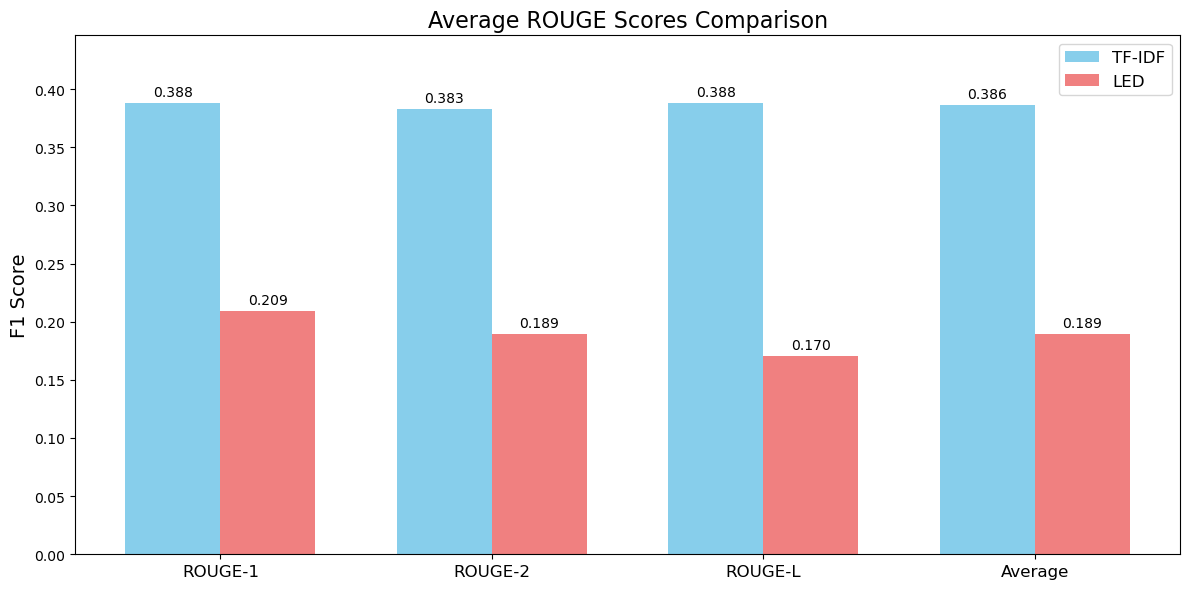

In [13]:
plt.figure(figsize = (12, 6))
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Average']
tfidf_scores = [avg_tfidf_rouge1, avg_tfidf_rouge2, avg_tfidf_rougeL, avg_tfidf_avg]
led_scores = [avg_led_rouge1, avg_led_rouge2, avg_led_rougeL, avg_led_avg]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize = (12, 6))
tfidf_bars = ax.bar(x - width/2, tfidf_scores, width, label = 'TF-IDF', color = 'skyblue')
led_bars = ax.bar(x + width/2, led_scores, width, label = 'LED', color = 'lightcoral')

ax.set_title('Average ROUGE Scores Comparison', fontsize=16)
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Add value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),  # 3 points vertical offset
                    textcoords = "offset points",
                    ha = 'center', va='bottom')

add_value_labels(tfidf_bars)
add_value_labels(led_bars)

plt.ylim(0, max(max(tfidf_scores), max(led_scores)) * 1.15)
plt.tight_layout()
plt.show()

In [14]:

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

def calculate_bleu(reference, summary):
    reference_tokens = reference.split()
    summary_tokens = summary.split()
    return sentence_bleu([reference_tokens], summary_tokens, smoothing_function=smoothie)

print("Calculating BLEU scores for TF-IDF summaries...")
df['tfidf_bleu'] = df.apply(lambda row: calculate_bleu(row['clean'], row['tfidf_summaries']), axis=1) 
print("Calculating BLEU scores for LED summaries...")
df['led_bleu'] = df.apply(lambda row: calculate_bleu(row['clean'], row['led_summaries']), axis=1)


Calculating BLEU scores for TF-IDF summaries...
Calculating BLEU scores for LED summaries...


In [15]:
!pip install bert_score
from bert_score import score as bert_score

print("Calculating BERTScores for TF-IDF summaries...")
P, R, F1 = bert_score(df['tfidf_summaries'].tolist(), df['clean'].tolist(), lang="en", verbose=True)
df['tfidf_bertscore'] = F1

print("Calculating BERTScores for LED summaries...")
P, R, F1 = bert_score(df['led_summaries'].tolist(), df['clean'].tolist(), lang="en", verbose=True)
df['led_bertscore'] = F1


Calculating BERTScores for TF-IDF summaries...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 20.47 seconds, 4.84 sentences/sec
Calculating BERTScores for LED summaries...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 19.62 seconds, 5.05 sentences/sec


In [16]:

print("\n=== AVERAGE BLEU & BERTScores ===")

print("TF-IDF:")
print(f"  Avg BLEU: {df['tfidf_bleu'].mean():.4f}")
print(f"  Avg BERTScore (F1): {df['tfidf_bertscore'].mean():.4f}")

print("\nLED:")
print(f"  Avg BLEU: {df['led_bleu'].mean():.4f}")
print(f"  Avg BERTScore (F1): {df['led_bertscore'].mean():.4f}")



=== AVERAGE BLEU & BERTScores ===
TF-IDF:
  Avg BLEU: 0.1141
  Avg BERTScore (F1): 0.8686

LED:
  Avg BLEU: 0.0438
  Avg BERTScore (F1): 0.8254


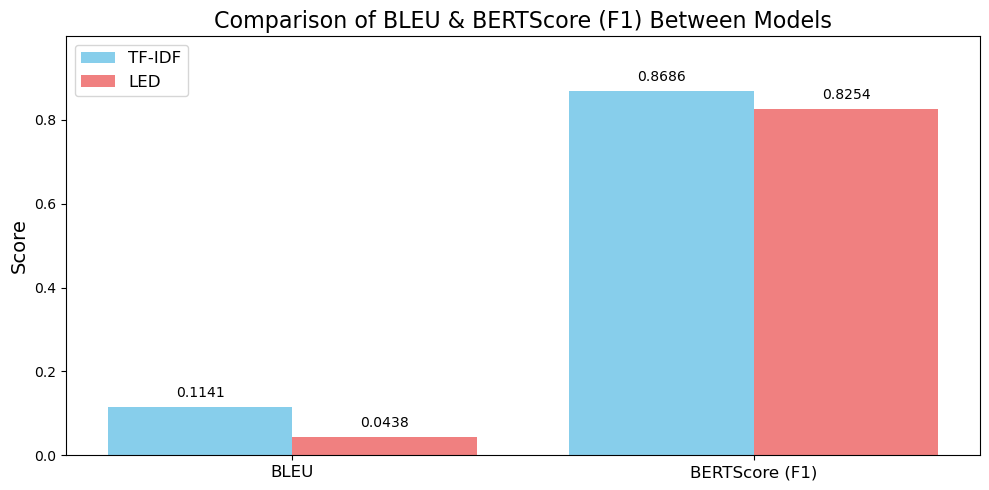

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting BLEU & BERTScore averages dynamically
models = ["TF-IDF", "LED"]
metrics = ["BLEU", "BERTScore (F1)"]

scores = np.array([
    [df['tfidf_bleu'].mean(), df['tfidf_bertscore'].mean()],  # TF-IDF Scores
    [df['led_bleu'].mean(), df['led_bertscore'].mean()]       # LED Scores
])

# Plot settings
x = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars
tfidf_bars = ax.bar(x - width/2, scores[0], width, label="TF-IDF", color="skyblue")
led_bars = ax.bar(x + width/2, scores[1], width, label="LED", color="lightcoral")

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel("Score", fontsize=14)
ax.set_title("Comparison of BLEU & BERTScore (F1) Between Models", fontsize=16)
ax.legend(fontsize=12)

# Add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center", va="bottom")

add_value_labels(tfidf_bars)
add_value_labels(led_bars)

plt.ylim(0, max(scores.flatten()) * 1.15)  # Adjust limit for better visibility
plt.tight_layout()
plt.show()


-Measures n-gram precision, showing how much the generated text matches exact phrases from the reference summary.
-TF-IDF (higher BLEU score) → More exact word match with the reference.
-LED (lower BLEU score) → More abstract paraphrasing, leading to fewer identical word sequences.

-Measures semantic similarity between generated and reference summaries.
-TF-IDF (higher BERTScore) → Preserves more word-level similarity.
-LED (lower BERTScore) → Rewrites sentences more abstractly, leading to slightly lower word alignment.